In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 719 kB 4.9 MB/s 
     |████████████████████████████████| 1.2 MB 55.4 MB/s 
     |████████████████████████████████| 197 kB 70.2 MB/s 
     |████████████████████████████████| 362 kB 62.8 MB/s 
     |████████████████████████████████| 4.2 MB 51.1 MB/s 
     |████████████████████████████████| 60 kB 6.7 MB/s 
     |████████████████████████████████| 212 kB 60.0 MB/s 
     |████████████████████████████████| 140 kB 61.3 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 69.0 MB/s 
     |████████████████████████████████| 596 kB 69.7 MB/s 
     |████████████████████████████████| 127 kB 65.9 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 271 kB 64.2 MB/s 
     |████████████████████████████████| 144 kB 71.9 MB/s 
     |████████████████████████████████| 6.6 MB 46.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the p

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
dblock = DataBlock()
dsets = dblock.datasets(df)

In [ ]:
def getX(r): return path/'train'/r['fname']
def getY(r): return r['labels'].split(' ')

In [ ]:
# return the indices that will be used for training set and validation set
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
    splitter=splitter,
    get_x=getX,
    get_y=getY,
    item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

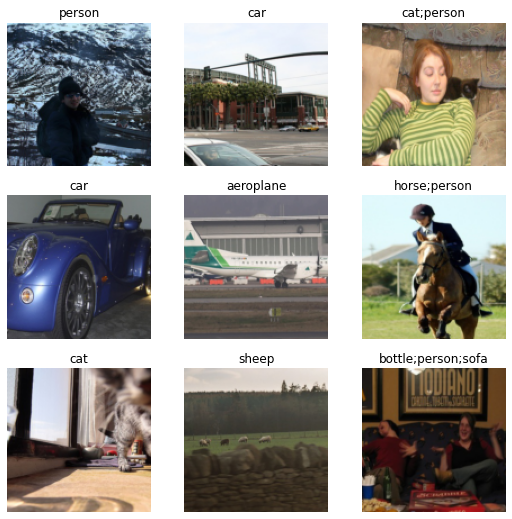

In [ ]:
dls.show_batch()

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  if sigmoid: inp = inp.sigmoid()
  return ((inp>=thresh)==targ.bool()).float().mean()


In [ ]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.cuda()

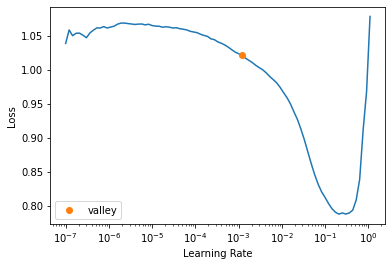

In [ ]:
best_lr = learn.lr_find()

In [ ]:
best_lr.valley

0.0012022644514217973

In [ ]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.942771,0.700725,0.241295,00:32
1,0.817336,0.558310,0.299502,00:32
2,0.599183,0.199001,0.828665,00:34
3,0.358807,0.124460,0.938944,00:32


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133563,0.118893,0.944343,00:33
1,0.115601,0.105974,0.951673,00:33
2,0.096273,0.103559,0.949223,00:33


In [ ]:
x,y = dls.train.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 20]))

In [ ]:
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [ ]:
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [ ]:
preds, targs = learn.get_preds()

In [ ]:
accuracy_multi(preds, targs, sigmoid=False)

TensorMultiCategory(0.9632)

In [ ]:
xs = torch.linspace(0.05, 0.95, 10000)

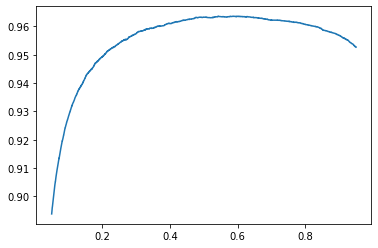

In [ ]:
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)